In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import random 
import shutil 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
dir_path = '/content/gdrive/MyDrive/data'

In [ ]:
folders = os.listdir(dir_path)
sub_folders = [os.path.join(dir_path, folder) for folder in folders]
files = [os.path.join(folder, files) for folder in sub_folders for files in os.listdir(folder)]

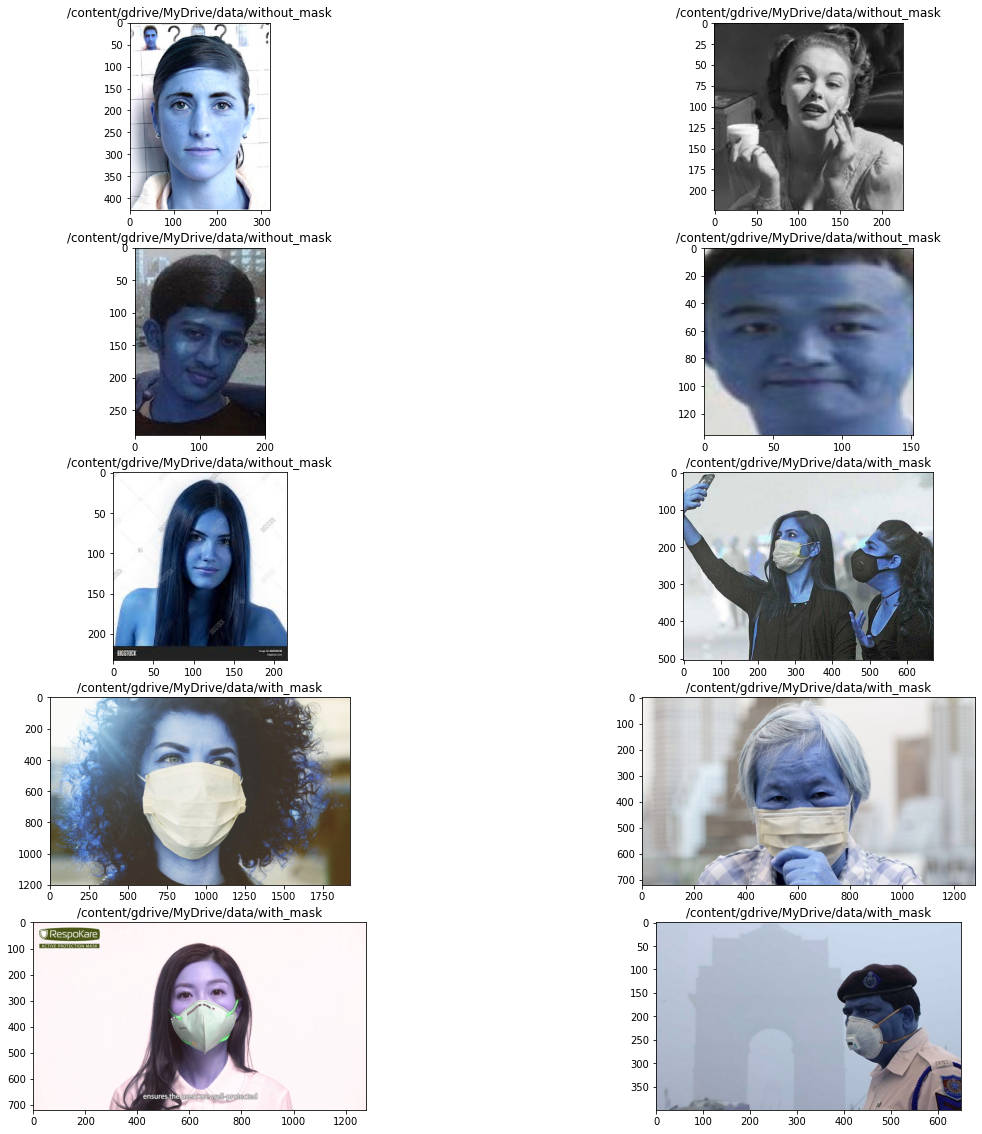

In [ ]:
# open a sample image from each class
plt.figure(figsize = (20,20))
i = 1
for folder in sub_folders:
    images = os.listdir(folder)[5:10]
    for image in images:
      img = cv2.imread(os.path.join(folder, image))
      plt.subplot(5,2,i)
      plt.title(folder)
      plt.imshow(img)
      i += 1

In [ ]:

folders = os.listdir(dir_path)
sub_folders = [os.path.join(dir_path, folder) for folder in folders]
sub_folders
no_mask_img_dir = sub_folders[0]
mask_img_dir = sub_folders[1]

no_mask_imgs = [file for file in os.listdir(no_mask_img_dir)]
mask_imgs = [file for file in os.listdir(mask_img_dir)]

random.seed(22)
random.shuffle(no_mask_imgs) 
random.shuffle(mask_imgs)

train_imgs_no_mask = no_mask_imgs[:int(len(no_mask_imgs)*0.8)]
train_imgs_mask = mask_imgs[:int(len(mask_imgs)*0.8)]

val_imgs_no_mask = no_mask_imgs[int(len(no_mask_imgs)*0.8):int(len(no_mask_imgs)*0.9)]
val_imgs_mask = mask_imgs[int(len(mask_imgs)*0.8):int(len(no_mask_imgs)*0.9)]

test_imgs_no_mask = no_mask_imgs[int(len(no_mask_imgs)*0.9):]
test_imgs_mask = mask_imgs[int(len(mask_imgs)*0.9):]


print(len(train_imgs_no_mask),len(train_imgs_mask),len(val_imgs_no_mask),len(val_imgs_mask), len(test_imgs_no_mask),len(test_imgs_mask))

3062 2980 383 465 383 373


In [ ]:
"""
train_write_path = '/content/gdrive/MyDrive/train'
val_write_path = '/content/gdrive/MyDrive/val'
test_write_path = '/content/gdrive/MyDrive/test'

os.mkdir(train_write_path)
os.mkdir(val_write_path)
os.mkdir(test_write_path)

# Just the directories
os.mkdir(os.path.join(train_write_path,'mask')) # 2 directoriss made mask and no mask
os.mkdir(os.path.join(train_write_path,'no_mask'))
os.mkdir(os.path.join(val_write_path,'mask'))
os.mkdir(os.path.join(val_write_path,'no_mask'))
"""

In [ ]:

"""
for file in train_imgs_no_mask:
  source = os.path.join(no_mask_img_dir,file)
  dest = os.path.join(train_write_path,'no_mask',file)
  shutil.copy(source, dest)

for file in train_imgs_mask:
  source = os.path.join(mask_img_dir,file)
  dest = os.path.join(train_write_path,'mask',file)
  shutil.copy(source, dest) 

for file in val_imgs_no_mask:
  source = os.path.join(no_mask_img_dir,file)
  dest = os.path.join(val_write_path,'no_mask',file)
  shutil.copy(source, dest)

for file in val_imgs_mask:
  source = os.path.join(mask_img_dir,file)
  dest = os.path.join(val_write_path,'mask',file)
  shutil.copy(source, dest) 

for file in test_imgs_no_mask:
  source = os.path.join(no_mask_img_dir,file)
  dest = os.path.join(test_write_path,file)
  shutil.copy(source, dest)

for file in test_imgs_mask:
  source = os.path.join(mask_img_dir,file)
  dest = os.path.join(test_write_path,file)
  shutil.copy(source, dest)
"""

In [ ]:
#pre-processing
train_datagen = ImageDataGenerator(rescale = 1.0/255.0, rotation_range = 40, zoom_range = 0.2, 
                                  shear_range = 0.2, width_shift_range = 0.2, height_shift_range = 0.2, 
                                  horizontal_flip = True, fill_mode = "nearest")

train_dir_path = '/content/gdrive/MyDrive/train'
# creating object of Training data generator class
train_generator = train_datagen.flow_from_directory(train_dir_path, target_size = (224,224), batch_size = 32, class_mode = "categorical")

Found 6042 images belonging to 2 classes.


In [ ]:
#pre-processing
val_datagen = ImageDataGenerator(rescale = 1.0/255.0, rotation_range = 40, zoom_range = 0.2, 
                                  shear_range = 0.2, width_shift_range = 0.2, height_shift_range = 0.2, 
                                  horizontal_flip = True, fill_mode = "nearest")

val_dir_path = '/content/gdrive/MyDrive/val'
# creating object of Training data generator class
val_generator = val_datagen.flow_from_directory(val_dir_path, target_size = (224,224), batch_size = 32, class_mode = "categorical")

Found 848 images belonging to 2 classes.


In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel) #
headModel = Flatten(name="flatten")(headModel) # flatten layer 
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel) 
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
# and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32
# compile our model
print("[INFO] compiling model...")

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	train_generator,
	epochs=EPOCHS,
  validation_data = val_generator,
  verbose = 1)

[INFO] compiling model...
[INFO] training head...
Epoch 1/10
149/189 [======================>.......] - ETA: 5:53 - loss: 0.5848 - accuracy: 0.7242

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


189/189 [==============================] - 1901s 10s/step - loss: 0.5407 - accuracy: 0.7529 - val_loss: 0.1606 - val_accuracy: 0.9611
Epoch 2/10
189/189 [==============================] - 88s 464ms/step - loss: 0.1695 - accuracy: 0.9470 - val_loss: 0.1132 - val_accuracy: 0.9623
Epoch 3/10
189/189 [==============================] - 87s 462ms/step - loss: 0.1181 - accuracy: 0.9651 - val_loss: 0.1021 - val_accuracy: 0.9658
Epoch 4/10
189/189 [==============================] - 87s 461ms/step - loss: 0.1011 - accuracy: 0.9675 - val_loss: 0.0952 - val_accuracy: 0.9611
Epoch 5/10
189/189 [==============================] - 87s 463ms/step - loss: 0.0915 - accuracy: 0.9671 - val_loss: 0.0804 - val_accuracy: 0.9693
Epoch 6/10
189/189 [==============================] - 87s 462ms/step - loss: 0.0855 - accuracy: 0.9742 - val_loss: 0.0945 - val_accuracy: 0.9587
Epoch 7/10
189/189 [==============================] - 87s 462ms/step - loss: 0.0802 - accuracy: 0.9727 - val_loss: 0.0782 - val_accuracy: 0.9